So far: Res with several plants in each node, dc load flow
To DO: Storages, Map of Germany with links

In [1]:
using JuMP
using Clp
using DataFrames
using LinearAlgebra
using CSV
using Plots

In [2]:
L_df = CSV.read("lines.csv")
N_df = CSV.read("nodes.csv")
P_df = CSV.read("plants.csv")
D_df = CSV.read("demand.csv")
R_df = CSV.read("res.csv")
S_df = CSV.read("storages.csv")

,index,node,g_max_s,mc,storage capacity,tech,efficiency
,String,Int64,Int64,Int64,Int64,String,Float64
1,s1,1,50,1,50,hydro,0.8
2,s2,2,100,0,100,battery,0.8


In [3]:
R_df

,timestep,wind,pv
,Int64,Int64,Int64
1,1,1,1
2,2,1,1


In [4]:
b = vec(Array(select(L_df,"b")))
A = zeros(nrow(L_df),nrow(N_df))
NODES = vec(Array(select(N_df,"index")))
SLACK = 14

#calculation of incidence matrix A
counter= 1
for i in eachrow(L_df)
    wert1 = L_df[counter,:][2]
    wert2 = L_df[counter,:][3]
    A[counter,wert1] =1
    A[counter,wert2] =-1
    global counter +=1
end

#calculate ptdf matrix source:EW-MOD lecture
function calculate_ptdf(A, b_vector, NODES, SLACK)
    """ Create PTDF Based on:
    Topology (A, incedence Matrix): LxN Matrix (1, -1) for nodes connected by line
    Susceptance Vector (B): Linesusceptance, calculated by line paramters and propotional to length
    NODES: Array of nodes
    SLACK: Reference Node to create the inversse of A.T * Bd A

    From documentation: PTDF = (Bd*A)(A.T * Bd * A)^-1
    Bd: Suceptance Vector (for each line) on Diagonal Matrix (LxL)
    Bl: Line Susceptance Matrix Bd*A
    Bn: Nodes Susceptance Matrix (A'*B)*A
    B_inv = Bn^-1 (without slack, otherwise singular)
    PTDF = Bl * B_inv
    """
    ## Calculation based on indices rather than Node Names (of type Str or Symb)
    idx_nodes = collect(1:length(NODES))
    idx_slack = findfirst(x -> x==SLACK, NODES)
    #A = incedence
    Bd = Diagonal(b_vector)
    Bl = Bd*A # Line suceptance Matrix
    Bn = (A'*Bd)*A # Nodes suceptance Matrix
    
    B_inv = zeros(length(NODES),length(NODES))
    B_inv[setdiff(idx_nodes,idx_slack), setdiff(idx_nodes,idx_slack)] = inv(Bn[setdiff(idx_nodes,idx_slack), setdiff(idx_nodes,idx_slack)])
    PTDF = Bl*B_inv
    return PTDF
end

ptdf = calculate_ptdf(A,b,NODES,SLACK);
ptdf

26×16 Array{Float64,2}:
  0.395689   -0.0208109  -0.0208109  …  0.0   0.00476269   0.0143332
  0.208622    0.0416217   0.0416217     0.0  -0.00952538  -0.0286665
  0.0         1.0         0.0           0.0   0.0          0.0
  0.395689   -0.0208109  -0.0208109     0.0   0.00476269   0.0143332
  0.395689   -0.0208109  -0.0208109     0.0   0.00476269   0.0143332
 -0.0748266   0.024973    0.024973   …  0.0  -0.00571523  -0.0171999
  0.133796    0.0665948   0.0665948     0.0  -0.0152406   -0.0458664
 -0.0101633   0.0313622   0.0313622     0.0  -0.01561     -0.0496577
 -0.157586   -0.197557   -0.197557      0.0   0.0367796    0.108008
  0.0         0.0         0.0           0.0   0.0          0.0
  0.123632    0.097957    0.097957   …  0.0  -0.0308506   -0.0955241
  0.0542806   0.0368759   0.0368759     0.0   0.0252909    0.0868315
  0.16775     0.166195    0.166195      0.0  -0.0211697   -0.0583503
 -0.208891   -0.215355   -0.215355      0.0  -0.0395905   -0.0746634
 -0.499727   -0.520493 

In [5]:
DISP = P_df[P_df.renewable .=="no",:].index #dispatchable plants
NDISP = P_df[P_df.renewable .=="yes",:].index #nondispatchable plants, shouldnt be that important
PLANTS = vec(Array(select(P_df,"index")))
LINES = vec(Array(select(L_df,"index"))) #lines
l_max = vec(Array(select(L_df,"lmax"))) #line maxes
T = [1,2] #timesteps
demand= D_df #demand dataframe
DISP

10-element Array{String,1}:
 "p2"
 "p4"
 "p7"
 "p8"
 "p9"
 "p10"
 "p12"
 "p13"
 "p15"
 "p16"

In [6]:
#df for disp plants

#make empty copy
DISP_PLANTS = copy(P_df)
NONDISP_PLANTS = copy(P_df)
deleterows!(DISP_PLANTS,1:16)
deleterows!(NONDISP_PLANTS,1:16)

for i in DISP
    f = P_df[P_df.index .==i,:]
    append!(DISP_PLANTS,f)
end
for i in NDISP
    f = P_df[P_df.index .==i,:]
    append!(NONDISP_PLANTS,f)
end
DISP_PLANTS

┌ Warning: `deleterows!(df::DataFrame, inds)` is deprecated, use `delete!(df, inds)` instead.
│   caller = top-level scope at In[6]:6
└ @ Core In[6]:6
┌ Warning: `deleterows!(df::DataFrame, inds)` is deprecated, use `delete!(df, inds)` instead.
│   caller = top-level scope at In[6]:7
└ @ Core In[6]:7


,index,node,tech,g_max_c,mc,renewable,g_max_r
,String,Int64,String,Int64,Int64,String,Int64
1,p18,5,pv,0,0,yes,50
2,p2,2,gas,50,15,no,0
3,p4,4,coal,250,8,no,0
4,p7,7,lignite,500,6,no,0
5,p8,8,coal,250,8,no,0
6,p9,9,coal,250,8,no,0
7,p10,10,gas,50,15,no,0
8,p12,12,lignite,250,6,no,0
9,p13,13,hydro,50,0,no,0


In [7]:
plants_at_node = Dict()
mc = Dict()
gmax_c = Dict()
for i in eachrow(P_df)
    if !haskey(plants_at_node,i["node"])
        plants_at_node[i["node"]]=[i["index"]]
    else
        push!(plants_at_node[i["node"]],i["index"])
    end
    mc[i["index"]] = i["mc"]
    gmax_c[i["index"]] = i["g_max_c"]
end
plants_at_node[SLACK]=[]
plants_at_node

Dict{Any,Any} with 16 entries:
  2  => ["p2"]
  16 => ["p16", "p17"]
  11 => ["p11"]
  7  => ["p7"]
  9  => ["p9"]
  10 => ["p10"]
  8  => ["p8"]
  6  => ["p6"]
  4  => ["p4"]
  3  => ["p3"]
  5  => ["p5", "p18"]
  13 => ["p13"]
  14 => Any[]
  15 => ["p15"]
  12 => ["p12"]
  1  => ["p1"]

In [8]:
#to enter slack
Kopie = copy(P_df)
push!(Kopie,["0" 14 "0" 0 0 "0" 0]);
Kopie

,index,node,tech,g_max_c,mc,renewable,g_max_r
,String,Int64,String,Int64,Int64,String,Int64
1,p1,1,wind,0,0,yes,250
2,p2,2,gas,50,15,no,0
3,p3,3,wind,0,0,yes,250
4,p4,4,coal,250,8,no,0
5,p5,5,wind,0,0,yes,250
6,p6,6,pv,0,0,yes,50
7,p7,7,lignite,500,6,no,0
8,p8,8,coal,250,8,no,0
9,p9,9,coal,250,8,no,0


In [9]:
#gmax_r für alle nodes, timesteps
#Capable for two res techs in a single node(pv and wind must be aggregated before hand)
gmax_r = Dict()
Techs = [1,2,3]#1=wind,2=pv,3=other



for n in NODES
    for t in T
        for i in Techs
            gmax_r[n,t,i] = 0
        end
        for i in 1:nrow(P_df[P_df.node .==n,:])
            if P_df[P_df.node .==n,:][i,:]["tech"] == "wind"
                gmax_r[n,t,1]= P_df[P_df.node .==n,:][i,:]["g_max_r"]*R_df[t,2]
            elseif P_df[P_df.node .==n,:][i,:]["tech"] == "pv"
                gmax_r[n,t,2] = P_df[P_df.node .==n,:][i,:]["g_max_r"]*R_df[t,3]
            end
        end
    end
end



gmax_r


Dict{Any,Any} with 96 entries:
  (4, 2, 2)  => 0
  (10, 2, 1) => 0
  (11, 1, 3) => 0
  (10, 1, 2) => 0
  (12, 2, 1) => 0
  (13, 2, 1) => 0
  (1, 2, 1)  => 250
  (15, 2, 2) => 0
  (3, 1, 2)  => 0
  (13, 2, 3) => 0
  (13, 1, 3) => 0
  (9, 1, 1)  => 0
  (5, 2, 3)  => 0
  (1, 2, 2)  => 0
  (7, 1, 3)  => 0
  (7, 2, 3)  => 0
  (16, 1, 2) => 50
  (10, 2, 2) => 0
  (4, 1, 2)  => 0
  (4, 1, 1)  => 0
  (8, 1, 1)  => 0
  (8, 2, 3)  => 0
  (14, 2, 2) => 0
  (2, 2, 1)  => 0
  (12, 1, 2) => 0
  ⋮          => ⋮

In [10]:
NODES = vec(Array(select(N_df,"index")))
NODESCOPY = copy(NODES)
for i in S_df.node
    filter!(x-> x !=i ,NODESCOPY)
end
NODESCOPY; 

In [11]:
#Storage Data Preparation
storage_at_node = Dict()
gmax_s = Dict()
mcs=Dict()
for i in eachrow(S_df)
    if !haskey(storage_at_node,i["node"])
        storage_at_node[i["node"]]=[i["index"]]
    else
        push!(storage_at_node[i["node"]],i["index"])
    end
    gmax_s[i["index"]] = i["g_max_s"]
    mcs[i["index"]] = i["mc"]
    
end

storage_at_node;
STORAGES = vec(Array(select(S_df,"index")));
gmax_s;#storage cap and g max are equal in each timestep
mcs;

for n in NODESCOPY
    storage_at_node[n] =[]
end
storage_at_node;

In [12]:
T=[1,2]
Ts = copy(T)
push!(Ts,length(T)+1)# Timesteps for storage levels

3-element Array{Int64,1}:
 1
 2
 3

In [13]:
gmax_r

Dict{Any,Any} with 96 entries:
  (4, 2, 2)  => 0
  (10, 2, 1) => 0
  (11, 1, 3) => 0
  (10, 1, 2) => 0
  (12, 2, 1) => 0
  (13, 2, 1) => 0
  (1, 2, 1)  => 250
  (15, 2, 2) => 0
  (3, 1, 2)  => 0
  (13, 2, 3) => 0
  (13, 1, 3) => 0
  (9, 1, 1)  => 0
  (5, 2, 3)  => 0
  (1, 2, 2)  => 0
  (7, 1, 3)  => 0
  (7, 2, 3)  => 0
  (16, 1, 2) => 50
  (10, 2, 2) => 0
  (4, 1, 2)  => 0
  (4, 1, 1)  => 0
  (8, 1, 1)  => 0
  (8, 2, 3)  => 0
  (14, 2, 2) => 0
  (2, 2, 1)  => 0
  (12, 1, 2) => 0
  ⋮          => ⋮

In [14]:
##Model

Fax = Model(Clp.Optimizer)
@variables Fax begin
    G[PLANTS,T] >= 0
    INJ[NODES,T]
    Gr[NODES,T] >= 0
    D[STORAGES,Ts]>=0
    Gs[STORAGES,Ts]>=0
    L[STORAGES,Ts]>=0
    
end

@objective(Fax, Min, sum(mc[disp] * G[disp,timestep] for disp in DISP, timestep in T)
                    +sum(mcs[s]*Gs[s,timestep] for s in STORAGES,timestep in T ));

@constraint(Fax, Max_Generation[plant=PLANTS,timestep = T],
            G[plant,timestep] <= gmax_c[plant]);

@constraint(Fax, Max_Gen_Res[node=NODES,timestep=T],
            Gr[node,timestep] <= sum(gmax_r[node,timestep,tech] for tech in Techs));
#so far so good



@constraint(Fax, EnergyBalance[node=NODES,timestep = T],
            sum(G[plant,timestep] for plant in plants_at_node[node])
            - demand[timestep,node]  + Gr[node,timestep] 
            - sum(D[s,timestep] for s in storage_at_node[node])
            + sum(Gs[s,timestep] for s in storage_at_node[node])== INJ[node,timestep]);


#storage constraints

@constraint(Fax,Input_Cap[s=STORAGES,timestep=T],
            D[s,timestep] <= gmax_s[s]);

@constraint(Fax,Generation_Cap[s=STORAGES,timestep=T],
            Gs[s,timestep] <= gmax_s[s]);

@constraint(Fax,Storage_Cap[s=STORAGES,timestep=T],
            L[s,timestep] <= gmax_s[s]);

@constraint(Fax,Storage_Level[s=STORAGES,timestep=2:length(T)],
            L[s,timestep+1]==L[s,timestep]-Gs[s,timestep]+D[s,timestep]);

@constraint(Fax,Start_Level[s=STORAGES],
            L[s,1]==gmax_s[s]);






#Line Constraints
@constraint(Fax, LineMax[line=LINES],
            sum(ptdf[line, node] * INJ[node,timestep] for node in NODES,timestep in T) <= l_max[line]
            );

@constraint(Fax, LineMin[line=LINES],
            sum(ptdf[line, node] * INJ[node,timestep] for node in NODES,timestep in T) >= -l_max[line]
            );

@constraint(Fax, sum(INJ[node,timestep] for node in NODES,timestep in T) == 0);

JuMP.optimize!(Fax)
JuMP.objective_value(Fax)

Coin0506I Presolve 52 (-115) rows, 24 (-92) columns and 782 (-884) elements
Clp0006I 0  Obj 0 Primal inf 46096.372 (20)
Clp0006I 24  Obj 5862.6981
Clp0000I Optimal - objective value 5862.6981
Coin0511I After Postsolve, objective 5862.6981, infeasibilities - dual 9.9999998 (2), primal 0 (0)
Coin0512I Presolved model was optimal, full model needs cleaning up
Clp0006I 0  Obj 5862.6981 Primal inf 1.8073486e-05 (2) Dual inf 2e+08 (2)
Clp0029I End of values pass after 2 iterations
Clp0006I 2  Obj 5862.6981
Clp0000I Optimal - objective value 5862.6981
Clp0032I Optimal objective 5862.698071 - 26 iterations time 0.002, Presolve 0.00


5862.698071218143

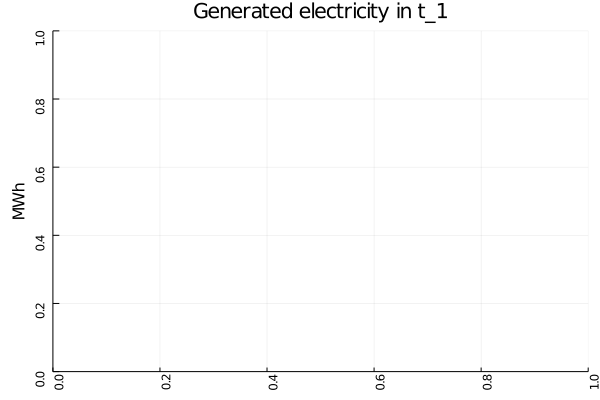

In [15]:
value.(G)
generation_t1 = DataFrame(Plants = PLANTS,
                        t = "t1",
                        DISP = value.(G).data[:,1]
                        )

generation_t2 = DataFrame(Plants = PLANTS,
                        t = "t2",
                        DISP = value.(G).data[:,2]
                        )

generation = vcat(generation_t1, generation_t2)

p1 = bar(x = PLANTS, y = generation_t1.DISP, leg=false, title="Generated electricity in t_1",
    ylabel="MWh", rotation=90)
plot(p1)

In [21]:
generation_t1.DISP

17-element Array{Float64,1}:
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
  50.0
  43.95349842613549
 499.99999999999994
   0.0
   0.0

In [16]:
value.(Gr)

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
    Dimension 2, [1, 2]
And data, a 16×2 Array{Float64,2}:
 250.0    112.213
   0.0      0.0
 215.248  250.0
   0.0      0.0
 300.0    300.0
  50.0     50.0
   0.0      0.0
   0.0      0.0
   0.0      0.0
   0.0      0.0
  50.0     50.0
   0.0      0.0
   0.0      0.0
   0.0      0.0
   0.0      0.0
  50.0     50.0

In [17]:
value.(Gs)

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, ["s1", "s2"]
    Dimension 2, [1, 2, 3]
And data, a 2×3 Array{Float64,2}:
   0.0    0.0  0.0
 100.0  100.0  0.0

In [18]:
value.(D)

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, ["s1", "s2"]
    Dimension 2, [1, 2, 3]
And data, a 2×3 Array{Float64,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0

In [19]:
value.(L)

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, ["s1", "s2"]
    Dimension 2, [1, 2, 3]
And data, a 2×3 Array{Float64,2}:
  50.0    0.0  0.0
 100.0  100.0  0.0

In [20]:
Price=dual.(EnergyBalance).data

16×2 Array{Float64,2}:
 0.0      0.0
 0.0      0.0
 0.0      0.0
 0.29404  0.29404
 0.58808  0.58808
 2.34787  2.34787
 2.64636  2.64636
 6.83459  6.83459
 5.3372   5.3372
 6.83459  6.83459
 4.39724  4.39724
 3.76817  3.76817
 6.93093  6.93093
 6.93093  6.93093
 5.0      5.0
 5.0      5.0